# Introduction
Hi visitor,
this is my first NLP project and my first competition on Kaggle. I am familliar with the theoretical basics of NLP but never did a project on this topics especially with some pretrained models. So this is it. 

In this project I tried two approaches of pre-trained model us. One where I load the pre-trained model manually in the embeddings layer and use that layer as a part of my model (glove) and the other one based on Huggingfaces🤗 framework, where I use the from_pretrained() function which loads the whole model (with all layers).

After the Competition:
For a better learning process I recaped my work and compared it with other competitions contributors work. One main notebook here was Jeremy Howards "Iterate like a grandmaster!". I used a lot of his approaches in this notebook in the recap phase. If you want to see my initial approach where I got around 70% accuracy you should take a look at version 14. This was the version that I submitted to the competition. All work after this version is part of the recap phase and therefore full of inspiring code parts of other contributors

INFO: According to the Kaggle dataset situation, I could find the Deberta base model there for Tensorflow therefore I needed to choose the roBerta model. So it could therefore occur the situation you find some variable / model / checkpoint names that are still named after deberta and not roberta. I will try to fix this one after the other.
And according to the current state of competition I focused on the Deberta/Roberta approach only which made my comment out the Glove model section. I will reactivate it in the final version of this notebook.

I thereforce ask you to bear with?! 🤗

# Imports and Datasets

In [1]:
import sys
assert sys.version_info >= (3,5)
import os
import pathlib

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
from datasets import Dataset
from datasets import DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

import nltk
from string import punctuation
from collections import Counter

from scipy.spatial.distance import cosine

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras.layers.merge import concatenate
from transformers import TrainingArguments
from transformers import BertTokenizer, TFDebertaModel
from transformers import RobertaTokenizer, TFRobertaModel, TFRobertaForSequenceClassification
from transformers import TFAutoModel

#import mlflow
#from mlflow import log_metric, log_param, log_artifacts
#import mlflow.tensorflow
#from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
else:
    print(f'---Tensorflow is running with GPU Power now---')
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
    


random_state=42
tf.random.set_seed(random_state)
np.random.seed(random_state)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
#kaggle = 0 # Kaggle path active = 1

MAIN_PATH = os.getcwd()

# change your local path here
if iskaggle:
    DATA_PATH = os.path.join(MAIN_PATH, '../input')
    PHRASES_PATH = os.path.join(DATA_PATH, 'us-patent-phrase-to-phrase-matching')
else:
    DATA_PATH = os.path.join(MAIN_PATH, 'data')
    PHRASES_PATH = os.path.join(DATA_PATH,'input\\us-patent-phrase-to-phrase-matching')



for dirname, _, filenames in os.walk(PHRASES_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

d:\anaconda3\envs\wingpuflake_keras_GPU\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow Version: 2.8.0
Keras Version: 2.8.0
---Tensorflow is running with GPU Power now---
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5

f:\python-workspace\phrase2phrase-match-ai\data\input\us-patent-phrase-to-phrase-matching\sample_submission.csv
f:\python-workspace\phrase2phrase-match-ai\data\input\us-patent-phrase-to-phrase-matching\test.csv
f:\python-workspace\phrase2phrase-match-ai\data\input\us-patent-phrase-to-phrase-matching\train.csv


# Get the Data

In [2]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'
CSV_FILE_COMF='sample_submission.csv'
CSV_FILE_CPC='titles.csv'
CPC_PATH='cpc-codes'
DEBERTA_PATH='huggingface-deberta-variants'
ROBERTA_PATH='roberta-base'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(PHRASES_PATH,CSV_FILE_TRAIN)
test = load_csv_data(PHRASES_PATH,CSV_FILE_TEST)
competition_file = load_csv_data(PHRASES_PATH,CSV_FILE_COMF)
cpc_code = load_csv_data(os.path.join(DATA_PATH, CPC_PATH), CSV_FILE_CPC)


print(f'Length of loaded trainset: {len(train)}')
print(f'Length of loaded testset: {len(test)}')
print(f'Length of loaded competition file: {len(competition_file)}')
print(f'Length of loaded cpc_codeset: {len(cpc_code)}')

Length of loaded trainset: 36473
Length of loaded testset: 36
Length of loaded competition file: 36
Length of loaded cpc_codeset: 260476


In [3]:
train = train.join(cpc_code.set_index('code'), on = 'context')
test = test.join(cpc_code.set_index('code'), on = 'context')

## Loading Model Files

In [4]:
# change your local path here
if iskaggle:
    path_to_glove_file = os.path.join(DATA_PATH, 'glove6b/glove.6B.300d.txt') # kaggle datasource location
else:
    path_to_glove_file = os.path.join(DATA_PATH,'glove.6B\\glove.6B.300d.txt')

In [5]:
if iskaggle:
    DEBERTA_BASE = os.path.join(DATA_PATH, DEBERTA_PATH + '/deberta-base/deberta-base') # kaggle datasource location
else:
    DEBERTA_BASE = 'microsoft/deberta-base'

In [6]:
if iskaggle:
    ROBERTA_BASE = os.path.join(DATA_PATH, ROBERTA_PATH) # kaggle datasource location
else:
    ROBERTA_BASE = 'roberta-base'

# Data Understanding

## Given Attributes
- id - a unique identifier for a pair of phrases
- anchor - the first phrase
- target - the second phrase
- context - the CPC classification (version 2021.05), which indicates the subject within which the similarity is to be scored
- score - the similarity. This is sourced from a combination of one or more manual expert ratings.


## Score
The scores are in the 0-1 range with increments of 0.25 with the following meanings:

- 1.0 - Very close match. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
- 0.75 - Close synonym, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
- 0.5 - Synonyms which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
- 0.25 - Somewhat related, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
- 0.0 - Unrelated.

In [7]:
train['anchor'].value_counts(dropna=False)

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

The anchor value has 733 different values. Lets look at the target value.

In [8]:
train['target'].value_counts(dropna=False)

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

The target looks a little bit different. Here we have 29,340 different values.

In [9]:
train['score'].value_counts(dropna=False)

0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: score, dtype: int64

<AxesSubplot:>

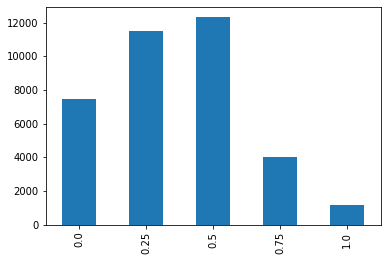

In [10]:
train['score'].value_counts(dropna=False).sort_index().plot.bar()

In [11]:
train.groupby(['anchor', 'context']).count()

id  target  score  title  section  class  subclass  \
anchor        context                                                       
abatement     A47      21      21     21     21       21     21         0   
              A61       3       3      3      3        3      3         0   
              A62       1       1      1      1        1      1         0   
              C01       1       1      1      1        1      1         0   
              F16       1       1      1      1        1      1         0   
...                    ..     ...    ...    ...      ...    ...       ...   
wiring trough F16      27      27     27     27       27     27         0   
              H02      18      18     18     18       18     18         0   
wood article  B05      28      28     28     28       28     28         0   
              B27       1       1      1      1        1      1         0   
              B44      27      27     27     27       27     27         0   

                       group  main_group  
anchor        context                     
abatement     A47          0           0  
              A61          0           0  
              A62          0           0  
              C01          0           0  
              F16          0           0  
...                      ...         ...  
wiring trough F16          0           0  
              H02          0           0  
wood article  B05          0           0  
              B27          0           0  
              B44          0           0  

[1699 rows x 9 columns]

### Configuration

In [12]:
class Config():
    learning_rate = 8e-6
    num_epochs = 4
    batch_size = 16
    decay = 0.01
    max_line_length = 135

    base_model = ROBERTA_BASE

    root_logdir_tb = "../../tensorboard-logs"   # tensorboard logdir

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            if k in self.__dict__:
                setattr(self, k, v)
            else:
                raise KeyError(k)
        


config = Config()

# Data Preparation

#### Loading Model

In [13]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [14]:
tokenizer = AutoTokenizer.from_pretrained(config.base_model)

In [15]:
model_pretrained = TFAutoModelForSequenceClassification.from_pretrained(config.base_model, trainable=True, return_dict=True, num_labels=5, output_hidden_states=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
#tokenizer.add_special_tokens({'additional_special_tokens': context_list})

#### Building the Input Value for the Model - The Text Corpus

Seperating the loaded cpc titles. They are concatenated by ";".  

In [17]:
# Seperating the cpc titles
train['title'] = train.title.apply(lambda text: text.split(';'))
train['title'] = train.title.apply(lambda context: ' '.join(context))

#### Special Tokens

In [18]:
sep_token = tokenizer.sep_token
print(f'Seperater Token: {sep_token}')

Seperater Token: </s>


In [19]:
tokenizer.all_special_tokens

['<s>', '</s>', '<unk>', '<pad>', '<mask>']

Defining the context as special token for the Tokenizer

In [20]:
train['context_token'] = '[' + train['context'] + ']'
test['context_token'] = '[' + test['context'] + ']'
context_list = list(train['context_token'].unique())

In [21]:
train['corpus'] = train['anchor'] + sep_token + train['target']
train['corpus_w_context'] = train['context_token'] + sep_token + train['corpus']
train['corpus_w_full_context'] = train['context_token'] + sep_token + train['corpus'] + sep_token + train['title']

test['corpus'] = test['anchor'] + sep_token + test['target']
test['corpus_w_context'] = test['context_token'] + sep_token + test['corpus']
test['corpus_w_full_context'] = train['context_token'] + sep_token + test['corpus'] + sep_token + test['title']

#### Train / Test / Val Data


In [22]:
anchors = train.anchor.unique()

In [23]:
print(f"Amount of diferent anchor values: {len(anchors)}")

Amount of diferent anchor values: 733


In [24]:
np.random.seed(random_state)
np.random.shuffle(anchors)

In [25]:
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

This anchor set will work as the basement for the validation set slicing.

In [26]:
val_proportion = 0.25
val_size = int(len(anchors)* val_proportion)
val_anchors = anchors[:val_size]

Slicing the data (or the over all index) with the validation index into train and validation index.

In [27]:
is_validation = np.isin(train.anchor, val_anchors)
idxs = np.arange(len(train))

In [28]:
val_indexes = idxs[is_validation]
train_indexes = idxs[~is_validation]
len(val_indexes), len(train_indexes)

(9116, 27357)

Distribution of "Score" Values in Train / Val Set

In [29]:
train.iloc[train_indexes].score.mean()

0.3623021530138539

In [30]:
train.iloc[val_indexes].score.mean()

0.3613426941641071

### Encoding

#### Tokenizer Funktion

In [31]:
def tokenize_fkt(text, tokenizer):
    MAX_LINE_LENGTH = len(tokenizer(text).input_ids) # removed the tensorflow return
    encoded_text = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=False,
        max_length=config.max_line_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="tf"
        )

    input_ids = np.array(encoded_text["input_ids"], dtype="int32")
    attention_masks = np.array(encoded_text["attention_mask"], dtype="int32")
    token_type_ids = np.array(encoded_text["token_type_ids"], dtype="int32")

    return {
        "input_ids": input_ids,
        "attention_masks": attention_masks,
        "token_type_ids": token_type_ids
    }

#### Dataset Train / Val

In [32]:
train_encoded = tokenize_fkt(train.loc[train_indexes]['corpus_w_full_context'].tolist(), tokenizer)
val_encoded = tokenize_fkt(train.loc[val_indexes]['corpus_w_full_context'].tolist(), tokenizer)


In [33]:
train_ds = tf.data.Dataset.from_tensor_slices((train_encoded, train.loc[train_indexes]['score'].tolist()))
val_ds = tf.data.Dataset.from_tensor_slices((val_encoded, train.loc[val_indexes]['score'].tolist()))

#### Batching Datasets

In [34]:
train_ds = (
    train_ds
    .shuffle(1024)
    .batch(config.batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(config.batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

## Model Build

In [35]:
def build_model(config,):
    input_ids = tf.keras.Input(shape = (config.max_line_length ), dtype = tf.int32, name="input_ids")
    attention_masks = tf.keras.Input(shape = (config.max_line_length), dtype = tf.int32, name="attention_masks")
    token_type_ids = tf.keras.Input(shape = (config.max_line_length ), dtype = tf.int32, name="token_type_ids")

    base_model = TFAutoModel.from_pretrained(
                                    config.base_model,
                                    trainable=True,
                                    return_dict=True,
                                    num_labels=1,
                                    output_hidden_states=True,
                                    from_pt=True
                                )

    base_model_out = base_model(
                            input_ids = input_ids,
                            attention_mask = attention_masks,
                            token_type_ids = token_type_ids,
                            output_hidden_states=True
                            )
    
    last_hidden_state = base_model_out.last_hidden_state

    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_state)
    dropout = tf.keras.layers.Dropout(0.3)(avg_pool)
    #x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

    model = tf.keras.models.Model(
        inputs = [input_ids, attention_masks, token_type_ids],
        outputs = output
    )

    model.compile(
        optimizer = tf.keras.optimizers.Nadam(learning_rate=config.learning_rate),
        loss = tf.keras.losses.BinaryCrossentropy()
    )

    return model
    

In [36]:
model = build_model(config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 135)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 135)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 135)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='multichannel.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### Helpers for Keras Training

In [42]:
#from keras.callbacks import ReduceLROnPlateau
#
## Tensorboard logging structure function
#root_logdir = "../../tensorboard-logs"
#
#def get_run_logdir(root_logdir, project):
#    '''
#    Returns logdir to the Tensorboard log for a specific project.
#
#            Parameters:
#                    root_logdir (str) : basic logdir from Tensorboard
#                    project (str): projectname that will be logged in TB
#
#            Returns:
#                    os.path (str): Path to the final logdir
#    '''
#    import time
#    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#    project_logdir = os.path.join(root_logdir,project)
#    return os.path.join(project_logdir, run_id)
#
#
#def lr_scheduler(epoch):
#  """
#  Returns a custom learning rate that decreases as epochs progress.
#  """
#  #decay = config.decay
#  #init_lr = config.learning_rate 
#
#  learning_rate = config.learning_rate * (1 / (1 + config.decay * epoch))
#
#  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
#  return learning_rate
#
#
#def lr_scheduler_2(epoch):
#    learning_rate = 2e-6 # 0.000006
#    if epoch == 0:
#        return learning_rate * 0.06 #0.000006
#    else:
#        return learning_rate * (0.9**epoch)
#
#
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(config.root_logdir_tb,"nlp_phrase2phrase"), histogram_freq=1)
#tensorboard_callback_roberta = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(config.root_logdir_tb,"nlp_phrase2phrase_roberta"), histogram_freq=1)
#lr_callback_roberta = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
#
#checkpoint_cb_roberta = keras.callbacks.ModelCheckpoint("trained_model_cp.h5", save_best_only=True, save_weights_only=True, monitor='val_loss', save_freq='epoch')
#earlystopping_roberta = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [43]:
#plt.plot([lr_scheduler(e) for e in range(10)])

In [37]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = config.num_epochs
)

Epoch 1/4
1710/1710 [==============================] - 508s 286ms/step - loss: 0.6019 - val_loss: 0.5703
Epoch 2/4
1710/1710 [==============================] - 489s 286ms/step - loss: 0.5680 - val_loss: 0.5608
Epoch 3/4
1710/1710 [==============================] - 486s 284ms/step - loss: 0.5526 - val_loss: 0.5636
Epoch 4/4
1710/1710 [==============================] - 522s 305ms/step - loss: 0.5427 - val_loss: 0.5602


In [40]:
model.save("roberta_trained_01.h5")

#### Loss Curves

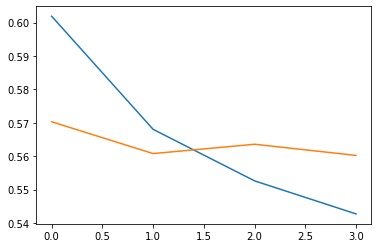

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Evaluation

## Test with all Validation Data [Roberta]

In [60]:
evaluation_roberta = model.evaluate((np.asarray(val_encoded['input_ids']),
                              np.asarray(val_encoded['attention_mask']),
                             ),
                             validating_labels, verbose=0)

print(f'Models validation loss: {evaluation_roberta[0]} - Models validation accuracy: {evaluation_roberta[1]}')

Models validation loss: 0.9118158221244812 - Models validation accuracy: 0.6363553404808044


# Submission File

## Training on all Data

## Prediction of Test File Values

In [63]:
#competition_file = pd.DataFrame(columns=['score'])
competition_file = pd.read_csv(PHRASES_PATH + "/sample_submission.csv")

In [64]:
test_encoded = preprocess_function(test)

In [65]:
test_prediction = model2.predict((np.asarray(test_encoded['input_ids']),
                                  np.asarray(test_encoded['attention_mask']) 
                                  ))

In [66]:
competition_file['score'] = encoder.inverse_transform(np.argmax(test_prediction, axis=1))

<AxesSubplot:>

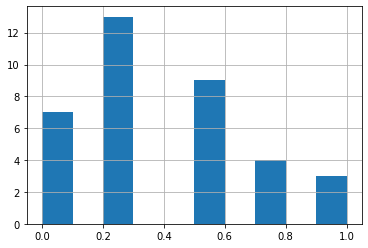

In [67]:
competition_file['score'].hist()

In [68]:
competition_file.to_csv('submission.csv', index=False)